In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import re
from scipy.misc import imresize
from mammo_utils import create_mask, half_image
%matplotlib inline

In [2]:
## rename the files to include the patient id so we can match the image up with the labels
## also copy the images to a single directory so we have them all in one place
def rename_and_copy_files(path, sourcedir="JPEG512", destdir="AllJPEGS512", scan_type="FULL"):
    directories = os.listdir(path+sourcedir)
    source_path = path + sourcedir + "/"
    destination_path = path + destdir + "/"
    
    # keep a counter so each file has a unique name
    i = 1
    
    # loop through the directories
    for directory in directories:
        # get the patient number and image type from the directory name
        patient_id = re.findall("_(P_[\d]+)_", directory)
        
        if len(patient_id) > 0:
            patient_id = str(patient_id[0])
        else:
            continue
        
        image_side = re.findall("_(LEFT|RIGHT)_", directory)
        
        if len(image_side) > 0:
            image_side = str(image_side[0])
        else:
            continue
        
        image_type = re.findall("(CC|MLO)", directory)
        if len(image_type) > 0:
            image_type = str(image_type[0])
        else:
            continue
        
        if not patient_id:
            continue
            
        # get the subdirectories
        subdir = os.listdir(source_path+directory)
        flag = False
        
        # get the next level of subdirectories
        if scan_type == 'FULL':
            subdir = subdir[0]
        elif (scan_type == "MASK") and (len(subdir) > 1):
            subdir = subdir[1]
        else:
            subdir = subdir[0]
            flag = True
            
        subsubdir = os.listdir(source_path+directory+'/'+subdir)
        if flag == False:
            files = os.listdir(source_path+directory+'/'+subdir+'/'+subsubdir[0])
            path = source_path+directory+'/'+subdir+'/'+subsubdir[0]
        else:
            try:
                if "mask" in str(subsubdir[0]):
                    files = os.listdir(source_path+directory+'/'+subdir+'/'+subsubdir[0])
                    path = source_path+directory+'/'+subdir+'/'+subsubdir[0]
                else:
                    files = os.listdir(source_path+directory+'/'+subdir+'/'+subsubdir[1])
                    path = source_path+directory+'/'+subdir+'/'+subsubdir[1]
            except:
                continue

        for file in files:
            # rename the file so we know where it came from, if image is not properly labeled skip it
            try:
                new_name = path+'/'+patient_id+'_'+image_side+'_'+image_type+'_'+scan_type+'.jpg'
                os.rename(path+'/'+file, new_name)
            except:
                print("Error:", new_name)
                continue
            
            # make sure the destination directory exists
            try:
                os.stat(destination_path)
            except:
                os.mkdir(destination_path)  
            
            # copy the files so they are all in one directory
            shutil.copy(new_name, destination_path)

        i += 1

## for the masks that are too big we are going to attempt to slice it into four slices, one for each corner.
## this function makes sure that the corners don't run off the image
def check_slice_corners(image_slice, full_image_arr, corners):
    h, w = image_slice.shape
    image_h, image_w = full_image_arr.shape
    
    # if the slice is the right shape return it
    if (h == 299) & (w == 299) and (np.mean(image_slice) > 25):
        return image_slice
    
    # else try to reframe it by checking each corner
    else:
        if corners[0] < 0:
            corners[0] = 0
            corners[1] = 299
        elif corners[1] > image_h:
            corners[1] = image_h
            corners[0] = image_h - 299
        
        if corners[2] < 0:
            corners[2] = 0
            corners[3] = 299
        elif corners[3] > image_w:
            corners[3] = image_w
            corners[2] = image_w - 299
            
        image_slice = full_image_arr[corners[0]:corners[1],corners[2]:corners[3]]
        
        # check that the slice contains useable info and doesn't just contain empty space
        if (np.mean(image_slice) > 25):
            return image_slice
    
    # else there is a problem, return an unusable array
    return np.array([0]).reshape((1,1))
        
## function to create ROI slices from masks and full images
## inputs: mask_dir and image_dir - paths to directories containing respective images
##         output - if True will output each file processed, 
##                  if False will only output errors and warnings, 
##                  if None won't ouput anything
## returns: numpy array of images and list of corresponding file names
def create_roi_slices(mask_dir, image_dir, output=True):
    # loop through mask directory
    mask_files = os.listdir(mask_dir)
    slices_list = []
    image_names_list = []

    for mask in mask_files:
        if output:
            print(mask)
        
        # open the full image
        image_file = mask.replace("MASK", "FULL")
        
        # some files have multiple masks, handle that case
        image_file = re.sub("(00\d+).jpg", ".jpg", image_file)
        base_image_file = image_file
        
        # try to open the image, if it doesn't exist continue
        try:
            full_image = PIL.Image.open(image_dir + "/" + image_file)
        except:
            # strip the image_file down to the bare name and then try some variations
            image_file = image_file.replace("_FULL", "")
            image_file = re.sub("_(\d).jpg", ".jpg", image_file)
            image_file = image_file.replace("000000", "")
            base_image_file = image_file.replace("000001", "")
            image_file = base_image_file.replace(".jpg", "000000.jpg")
            try:
                full_image = PIL.Image.open(image_dir + "/" + image_file)
            except:
                image_file = base_image_file.replace(".jpg", "_FULL.jpg")
                try:
                    full_image = PIL.Image.open(image_dir + "/" + image_file)
                except:
                    print("Error:", image_file)
                    continue

        # scale the full image to half size
        full_image = half_image(full_image)
        image_h, image_w = full_image.size
        
        # turn it into an array
        full_image_arr = np.array(full_image)
        
        # get rid of the extra dimensions with unneccessary info
        full_image_arr = full_image_arr[:,:,0]
        image_h, image_w = full_image_arr.shape
        
        # get the mask, if the mask is bigger than the slice we will create multiple slices 
        # using the corners of the mask. 
        center_row, center_col, too_big = create_mask(mask_dir + "/" + mask, full_image_arr)
        
        # if there is a problem then skip this one
        if (center_row == 0) and (center_col == 0):
            continue
        
        # if the mask (with 20 pixel margin) will fit in one slice do that
        if not too_big:
            full_image_slice = full_image_arr[center_row-150:center_row+149,center_col-150:center_col+149]
        
        # otherwise if the mask is too big we are going to cut the ROI into multiple slices so each contains an edge
        else:
            if output is not None:
                print(mask, "Mask too big, reframing...")
                
            # get the height and width of the mask
            mask_height = center_row[1] - center_row[0]
            mask_width = center_col[1] - center_col[0]
            
            mask_too_high = mask_height > 309
            mask_too_wide = mask_width > 309
            
            # first let's size the abnormality down so it fits in one slice and use that as well
            mask_size = np.max([mask_height, mask_width])
            
            use_full_slice = False
            full_image_slice = full_image_arr[center_row[0] - 10:center_row[0] + mask_size,center_col[0] - 10:center_col[0] + mask_size]
            
            # if the slice isn't shaped right just ignore it, this isn't important enough to try to reshape it
            if full_image_slice.shape[0] == full_image_slice.shape[1]:
                try:
                    full_image_slice = imresize(full_image_slice, (299,299))
                    use_full_slice = True
                except:
                    use_full_slice = False
            
            # let's create the set of corners for each slice
            slice_1_corners = [center_row[0], center_row[0] + 299, center_col[0], center_col[0]+299]
            slice_2_corners = [center_row[0], center_row[0] + 299, center_col[1] - 299, center_col[1]]
            slice_3_corners = [center_row[1] - 299, center_row[1], center_col[0], center_col[0] + 299]
            slice_4_corners = [center_row[1] - 299, center_row[1], center_col[1] - 299, center_col[1]]
            
            # now let's cut the ROI into up to four slices so that each contains an edge
            if mask_too_wide:
                full_image_slice_1 = full_image_arr[center_row[0]:center_row[0]+299,center_col[0]:center_col[0]+299]
                full_image_slice_2 = full_image_arr[center_row[0]:center_row[0]+299,center_col[1]-299:center_col[1]]
                
                # check the shape of the slices
                full_image_slice_1 = check_slice_corners(full_image_slice_1, full_image_arr, slice_1_corners)
                full_image_slice_2 = check_slice_corners(full_image_slice_2, full_image_arr, slice_2_corners)
            
            # if the mask is not too wide create slices that will fail the test and not be used
            else:
                full_image_slice_1 = np.array([0]).reshape(1,1)
                full_image_slice_2 = np.array([0]).reshape(1,1)
                
            if mask_too_high:
                full_image_slice_3 = full_image_arr[center_row[1]-299:center_row[1],center_col[0]:center_col[0]+299]
                full_image_slice_4 = full_image_arr[center_row[1]-299:center_row[1],center_col[1]-299:center_col[1]]            
                
                # check the shapes
                full_image_slice_3 = check_slice_corners(full_image_slice_3, full_image_arr, slice_3_corners)
                full_image_slice_4 = check_slice_corners(full_image_slice_4, full_image_arr, slice_4_corners)
            
            # if the mask is not too high create slices that will fail the test and not be used    
            else:
                full_image_slice_3 = np.array([0]).reshape(1,1)
                full_image_slice_4 = np.array([0]).reshape(1,1)
                
        # if the slice is the wrong shape the mask must be too close to the edges of the scan, move it so it fits
        if full_image_slice.shape != (299,299) and not too_big:
            if (center_row - 150 < 0):
                center_row = 150
            elif center_row + 150 > image_h:
                center_row = image_h - 150
            
            if center_col - 150 < 0:
                center_col = 150
            elif center_col + 150 > image_w:
                center_col = image_w - 150
            
            if not too_big:
                full_image_slice = full_image_arr[center_row-150:center_row+149,center_col-150:center_col+149]
            elif output is not None:
                print(mask, "Slice is wrong size:")
        
        # if the main slice is the right shape add it to the list
        if full_image_slice.shape == (299,299):
            slices_list.append(full_image_slice.reshape(299,299,1))
            image_names_list.append(base_image_file.replace("_FULL", ""))
        
        # if we have multiple slices check them
        if too_big:
            if full_image_slice_1.shape == (299,299):
                slices_list.append(full_image_slice_1.reshape(299,299,1))
                image_names_list.append(base_image_file.replace("_FULL", ""))
            elif output is not None:
                print("Slice_1 wrong shape:", full_image_slice_1.shape, "- image", base_image_file)
                
            if full_image_slice_2.shape == (299,299):
                slices_list.append(full_image_slice_2.reshape(299,299,1))
                image_names_list.append(base_image_file.replace("_FULL", ""))
            elif output is not None:
                print("Slice_2 wrong shape:", full_image_slice_2.shape, "- image", base_image_file)
                
            if full_image_slice_3.shape == (299,299):
                slices_list.append(full_image_slice_3.reshape(299,299,1))
                image_names_list.append(base_image_file.replace("_FULL", ""))
            elif output is not None:
                print("Slice_3 wrong shape:", full_image_slice_3.shape, "- image", base_image_file)
                
            if full_image_slice_4.shape == (299,299):
                slices_list.append(full_image_slice_4.reshape(299,299,1))
                image_names_list.append(base_image_file.replace("_FULL", ""))
            elif output is not None:
                print("Slice_4 wrong shape:", full_image_slice_4.shape, "- image", base_image_file)
        
    return np.array(slices_list), image_names_list

## Mass Train

In [11]:
# copy all of the masks into one directory, renaming them appropriately
rename_and_copy_files("D:\\Documents\\Mammography\\CBIS-DDSM\\", "Mass Train ROI JPEGs", "Mass Train All Mask JPEGs Full", scan_type="MASK")
rename_and_copy_files("D:\\Documents\\Mammography\\CBIS-DDSM\\", "Mass Train JPEGs Full 2", "Mass Train All JPEGs Full", scan_type="FULL")

Error: Patient-Mass-Training_P_00779_LEFT_CC_1/Study_DDSM_MG[20160720]
Error: Patient-Mass-Training_P_01849_RIGHT_MLO_1/Study_DDSM_MG[20160720]


In [4]:
## go through the directories and crop out the ROI from the full image using the mask
mask_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Mass Train All Mask JPEGs Full"
image_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Mass Train All JPEGs Full"

mass_train_slices, mass_train_image_names = create_roi_slices(mask_dir, image_dir, output=False)

P_00044_RIGHT_MLO_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00044_RIGHT_MLO_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00044_RIGHT_MLO_FULL.jpg


C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


P_00051_LEFT_CC_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00051_LEFT_CC_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00051_LEFT_CC_FULL.jpg
P_00051_LEFT_MLO_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00051_LEFT_MLO_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00051_LEFT_MLO_FULL.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_00059_LEFT_CC000000.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_00059_LEFT_MLO_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_00108_LEFT_CC_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_00108_LEFT_MLO_MASK.jpg
P_00110_LEFT_CC_MASK.jpg Mask too big, reframing...
P_00110_LEFT_MLO_MASK.jpg Mask too big, reframing...
P_00120_LEFT_CC_MASK.jpg Mask too big, reframing...
Slice_1 w

P_00903_LEFT_MLO_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00903_LEFT_MLO_FULL.jpg
Slice_4 wrong shape: (1, 1) - image P_00903_LEFT_MLO_FULL.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_00915_RIGHT_CC_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_00915_RIGHT_MLO_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_00927_LEFT_MLO_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_00949_LEFT_CC_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_00949_LEFT_MLO_MASK.jpg
P_00958_LEFT_MLO_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00958_LEFT_MLO_FULL.jpg
Slice_4 wrong shape: (1, 1) - image P_00958_LEFT_MLO_FULL.jpg
P_00978_RIGHT_MLO_MASK.jpg Mask too big, 

Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_01831_RIGHT_MLO_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_01908_LEFT_CC_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_01946_RIGHT_MLO_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_01981_RIGHT_CC_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_01981_RIGHT_MLO_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_01983_LEFT_MLO_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_02033_RIGHT_CC_MASK.jpg
Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Train All Mask JPEGs Full/P_02033_RIGHT_MLO_MASK.jpg
Mishaped mask, resizing mask 

In [5]:
print("Mass Train Slices shape:",mass_train_slices.shape)
print("Mass Train File Name List:", len(mass_train_image_names))

Mass Train Slices shape: (1469, 299, 299, 1)
Mass Train File Name List: 1469


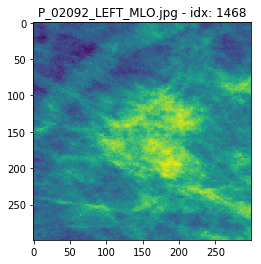

In [17]:
# P_00059_LEFT_CC
for i in range(len(mass_train_image_names)):
    if mass_train_image_names[i] == "P_02092_LEFT_MLO.jpg":
        plt.imshow(mass_train_slices[i].reshape(299,299))
        plt.title("P_02092_LEFT_MLO.jpg - idx: " + str(i))
        plt.show()

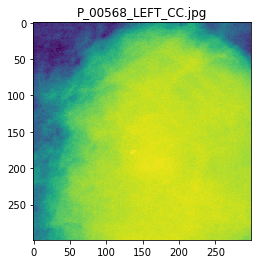

In [13]:
# check image to make sure it matches the cropped image
plt.imshow(mass_train_slices[437].reshape(299,299))
plt.title(mass_train_image_names[437])

In [14]:
# process labels for slices
train_labels = pd.read_pickle(os.path.join("data", "train_labels.pkl"))
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

#mass_train_image_names = np.load(os.path.join("data", "mass_train_filenames.npy"))
mass_train_labels = []

for image in mass_train_image_names:
    label = train_labels.loc[image]['CLASS']
    mass_train_labels.append(label)
    
mass_train_labels = np.array(mass_train_labels)
print("Mass Train Labels:", len(mass_train_labels))

Mass Train Labels: 1469


In [15]:
np.save(os.path.join("data", "mass_train_slices.npy"), mass_train_slices)
np.save(os.path.join("data", "mass_train_filenames.npy"), mass_train_image_names)
np.save(os.path.join("data", "mass_train_labels.npy"), mass_train_labels)

## Calc Train

In [42]:
# copy all of the masks into one directory, renaming them appropriately
rename_and_copy_files("D:\\Documents\\Mammography\\CBIS-DDSM\\", "Calc Train ROI JPEGsl", "Calc Train All Mask JPEGs Full", scan_type="MASK")
rename_and_copy_files("D:\\Documents\\Mammography\\CBIS-DDSM\\", "Calc Train All JPEGs Full", "Calc Train All Full JPEGs", scan_type="FULL")

In [18]:
## go through the directories and crop out the ROI from the full image using the mask
mask_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Calc Train All Mask JPEGs Full"
image_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Calc Train All Full JPEGs"

calc_train_slices, calc_train_image_names = create_roi_slices(mask_dir, image_dir, output=False)

P_00005_RIGHT_CC_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00005_RIGHT_CC_FULL.jpg
Slice_4 wrong shape: (1, 1) - image P_00005_RIGHT_CC_FULL.jpg


C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


P_00005_RIGHT_MLO_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00005_RIGHT_MLO_FULL.jpg
Slice_4 wrong shape: (1, 1) - image P_00005_RIGHT_MLO_FULL.jpg
P_00007_LEFT_CC_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00007_LEFT_CC_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00007_LEFT_CC_FULL.jpg
P_00007_LEFT_MLO_MASK.jpg Mask too big, reframing...
P_00012_LEFT_CC_MASK.jpg Mask too big, reframing...
P_00012_LEFT_MLO_MASK.jpg Mask too big, reframing...
P_00013_RIGHT_MLO_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00013_RIGHT_MLO_FULL.jpg
Slice_4 wrong shape: (1, 1) - image P_00013_RIGHT_MLO_FULL.jpg
P_00019_RIGHT_CC_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00019_RIGHT_CC_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00019_RIGHT_CC_FULL.jpg
P_00019_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_00030_LEFT_CC_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 

P_00534_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_00546_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_00551_RIGHT_CC_MASK.jpg Mask too big, reframing...
P_00551_RIGHT_MLO_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00551_RIGHT_MLO_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00551_RIGHT_MLO_FULL.jpg
P_00573_RIGHT_CC_MASK.jpg Mask too big, reframing...
P_00573_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_00574_RIGHT_CC_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00574_RIGHT_CC_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00574_RIGHT_CC_FULL.jpg
P_00574_RIGHT_MLO_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00574_RIGHT_MLO_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00574_RIGHT_MLO_FULL.jpg
P_00582_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_00584_LEFT_CC_MASK.jpg Mask too big, reframing...
P_00591_RIGHT_CC_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image 

P_01099_LEFT_MLO_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_01099_LEFT_MLO_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_01099_LEFT_MLO_FULL.jpg
P_01099_RIGHT_MLO_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_01099_RIGHT_MLO_FULL.jpg
P_01102_LEFT_CC_MASK.jpg Mask too big, reframing...
P_01102_LEFT_MLO_MASK.jpg Mask too big, reframing...
P_01108_LEFT_CC_MASK.jpg Mask too big, reframing...
P_01108_LEFT_MLO_MASK.jpg Mask too big, reframing...
P_01116_LEFT_CC_MASK.jpg Mask too big, reframing...
P_01116_LEFT_MLO_MASK.jpg Mask too big, reframing...
P_01122_LEFT_MLO_MASK.jpg Mask too big, reframing...
P_01127_RIGHT_CC_MASK.jpg Mask too big, reframing...
P_01127_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_01135_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_01136_RIGHT_CC_MASK.jpg Mask too big, reframing...
P_01136_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_01143_RIGHT_CC_MASK.jpg Mask too big, reframing...
P_01156_LEFT_CC_M

P_01683_LEFT_CC_MASK.jpg Mask too big, reframing...
P_01688_RIGHT_MLO_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_01688_RIGHT_MLO_FULL.jpg
Slice_4 wrong shape: (1, 1) - image P_01688_RIGHT_MLO_FULL.jpg
P_01724_LEFT_MLO_MASK.jpg Mask too big, reframing...
P_01729_LEFT_CC_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_01729_LEFT_CC_FULL.jpg
Slice_4 wrong shape: (1, 1) - image P_01729_LEFT_CC_FULL.jpg
P_01729_LEFT_MLO_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_01729_LEFT_MLO_FULL.jpg
Slice_4 wrong shape: (1, 1) - image P_01729_LEFT_MLO_FULL.jpg
P_01736_RIGHT_CC_MASK.jpg Mask too big, reframing...
P_01736_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_01748_RIGHT_CC_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_01748_RIGHT_CC_FULL.jpg
Slice_4 wrong shape: (1, 1) - image P_01748_RIGHT_CC_FULL.jpg
P_01750_LEFT_CC_MASK.jpg Mask too big, reframing...
P_01750_LEFT_MLO_MASK.jpg Ma

In [19]:
print("Calc Train Slices shape:",calc_train_slices.shape)
print("Calc Train File Name List:", len(calc_train_image_names))

Calc Train Slices shape: (2345, 299, 299, 1)
Calc Train File Name List: 2345


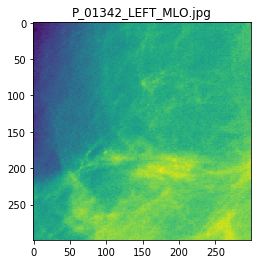

In [20]:
# check image to make sure it matches the cropped image
plt.imshow(calc_train_slices[1509].reshape(299,299))
plt.title(calc_train_image_names[1509])

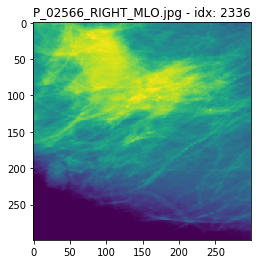

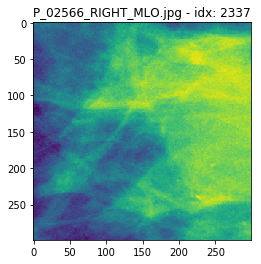

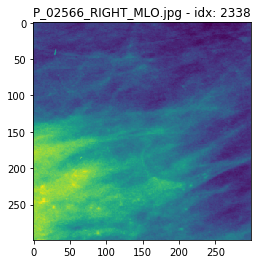

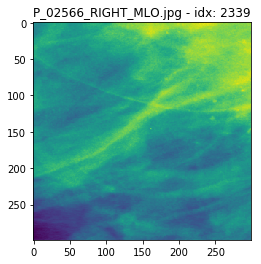

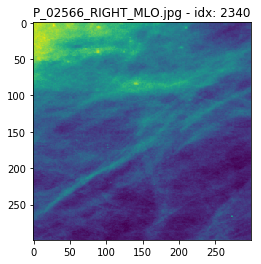

In [21]:
# P_00059_LEFT_CC
for i in range(len(calc_train_image_names)):
    if calc_train_image_names[i] == "P_02566_RIGHT_MLO.jpg":
        plt.imshow(calc_train_slices[i].reshape(299,299))
        plt.title("P_02566_RIGHT_MLO.jpg - idx: " + str(i))
        plt.show()

In [22]:
calc_train_labels = []
train_labels = pd.read_pickle(os.path.join("data", "train_labels.pkl"))
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

#calc_train_image_names = np.load("data/calc_train_filenames.npy")

for image in calc_train_image_names:
    calc_train_labels.append(train_labels.loc[image]['CLASS'])
    
print("Calc Train Labels:", len(calc_train_labels))

Calc Train Labels: 2345


In [23]:
np.save(os.path.join("data", "calc_train_slices.npy"), calc_train_slices)
np.save(os.path.join("data", "calc_train_filenames.npy"), calc_train_image_names)
np.save(os.path.join("data", "calc_train_labels.npy"), np.array(calc_train_labels))

## Mass Test

In [70]:
# copy all of the masks into one directory, renaming them appropriately
rename_and_copy_files("D:\\Documents\\Mammography\\CBIS-DDSM\\", "Mass Test ROI JPEGs", "Mass Test All Mask JPEGs", scan_type="MASK")
rename_and_copy_files("D:\\Documents\\Mammography\\CBIS-DDSM\\", "Mass Test Full JPEGs", "Mass Test All Full JPEGs", scan_type="FULL")

In [24]:
## go through the directories and crop out the ROI from the full image using the mask
mask_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Mass Test All Mask JPEGs"
image_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Mass Test All Full JPEGs"

mass_test_slices, mass_test_image_names = create_roi_slices(mask_dir, image_dir, output=False)

Mishaped mask, resizing mask D:\Documents\Mammography\CBIS-DDSM\Mass Test All Mask JPEGs/P_00145_LEFT_CC_MASK.jpg


C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Mask shape doesn't match image! D:\Documents\Mammography\CBIS-DDSM\Mass Test All Mask JPEGs/P_00145_LEFT_MLO_MASK.jpg
Mask shape: (2185, 1077)
Image shape: (2513, 1238)
P_00192_RIGHT_CC_MASK.jpg Mask too big, reframing...
P_00194_RIGHT_CC_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00194_RIGHT_CC_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00194_RIGHT_CC_FULL.jpg
P_00194_RIGHT_MLO_MASK.jpg Mask too big, reframing...
P_00200_LEFT_CC_MASK.jpg Mask too big, reframing...
P_00200_RIGHT_CC_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00200_RIGHT_CC_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00200_RIGHT_CC_FULL.jpg
P_00296_LEFT_CC_MASK.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00296_LEFT_CC_FULL.jpg
Slice_2 wrong shape: (1, 1) - image P_00296_LEFT_CC_FULL.jpg
P_00296_LEFT_MLO_MASK.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00296_LEFT_MLO_FULL.jpg
Slice_4 wrong shape: (1, 1) -

In [25]:
print("Mass Test Slices shape:", mass_test_slices.shape)
print("Mass Test File Name List:", len(mass_test_image_names))

Mass Test Slices shape: (413, 299, 299, 1)
Mass Test File Name List: 413


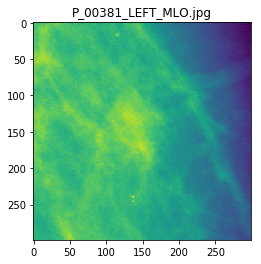

In [26]:
# check images to make sure it matches the cropped image
plt.imshow(mass_test_slices[99].reshape(299,299))
plt.title(mass_test_image_names[99])

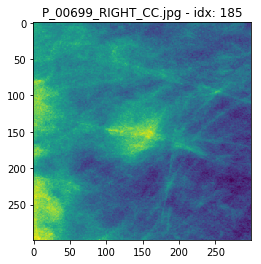

In [27]:
# P_00059_LEFT_CC
for i in range(len(mass_test_image_names)):
    if mass_test_image_names[i] == "P_00699_RIGHT_CC.jpg":
        plt.imshow(mass_test_slices[i].reshape(299,299))
        plt.title("P_00699_RIGHT_CC.jpg - idx: " + str(i))
        plt.show()

In [28]:
# process labels for slices
test_labels = pd.read_pickle(os.path.join("data", "test_labels.pkl"))

test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])
mass_test_labels = []

for image in mass_test_image_names:
    label = test_labels.loc[image]['CLASS']
    mass_test_labels.append(test_labels.loc[image]['CLASS'])
    
print("Mass Test Labels:", len(mass_test_labels))

Mass Test Labels: 413


In [29]:
np.save(os.path.join("data", "mass_test_slices.npy"), mass_test_slices)
np.save(os.path.join("data", "mass_test_filenames.npy"), mass_test_image_names)
np.save(os.path.join("data", "mass_test_labels.npy"), np.array(mass_test_labels))

## Calc Test

In [10]:
# copy all of the masks into one directory, renaming them appropriately
rename_and_copy_files("D:\\Documents\\Mammography\\CBIS-DDSM\\", "Calc Test ROI JPEGs", "Calc Test All Mask JPEGs", scan_type="MASK")
rename_and_copy_files("D:\\Documents\\Mammography\\CBIS-DDSM\\", "Calc Test Full JPEGs", "Calc Test All Full JPEGs", scan_type="FULL")

In [31]:
## go through the directories and crop out the ROI from the full image using the mask
mask_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Calc Test All Mask JPEGs"
image_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Calc Test All Full JPEGs"

calc_test_slices, calc_test_image_names = create_roi_slices(mask_dir, image_dir, output=False)

P_00038_RIGHT_CC000001.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00038_RIGHT_CC.jpg
Slice_4 wrong shape: (1, 1) - image P_00038_RIGHT_CC.jpg
P_00038_RIGHT_CC000001_1.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00038_RIGHT_CC.jpg
Slice_4 wrong shape: (1, 1) - image P_00038_RIGHT_CC.jpg
P_00038_RIGHT_MLO000001.jpg Mask too big, reframing...


C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


P_00038_RIGHT_MLO000001_1.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00038_RIGHT_MLO.jpg
Slice_4 wrong shape: (1, 1) - image P_00038_RIGHT_MLO.jpg
P_00132_LEFT_MLO000001.jpg Mask too big, reframing...
Slice_1 wrong shape: (1, 1) - image P_00132_LEFT_MLO.jpg
Slice_2 wrong shape: (1, 1) - image P_00132_LEFT_MLO.jpg
P_00180_LEFT_CC000001.jpg Mask too big, reframing...
P_00180_LEFT_MLO000001.jpg Mask too big, reframing...
P_00195_LEFT_CC000001.jpg Mask too big, reframing...
Slice_3 wrong shape: (1, 1) - image P_00195_LEFT_CC.jpg
Slice_4 wrong shape: (1, 1) - image P_00195_LEFT_CC.jpg
P_00202_RIGHT_CC000001.jpg Mask too big, reframing...
P_00202_RIGHT_MLO000001.jpg Mask too big, reframing...
P_00299_LEFT_MLO000001.jpg Mask too big, reframing...
P_00299_RIGHT_CC000001.jpg Mask too big, reframing...
P_00299_RIGHT_MLO000001.jpg Mask too big, reframing...
Error: P_00353_LEFT_CC1_FULL.jpg
Error: P_00353_LEFT_CC2_FULL.jpg
P_00368_LEFT_CC000001.jpg Mask too big, reframing

P_02432_LEFT_MLO000001.jpg Mask too big, reframing...
P_02464_RIGHT_CC000001.jpg Mask too big, reframing...
P_02464_RIGHT_MLO000001.jpg Mask too big, reframing...
P_02501_RIGHT_MLO000001.jpg Mask too big, reframing...


In [32]:
print("Calc Test Slices shape:", calc_test_slices.shape)
print("Calc Test File Name List:", len(calc_test_image_names))

Calc Test Slices shape: (559, 299, 299, 1)
Calc Test File Name List: 559


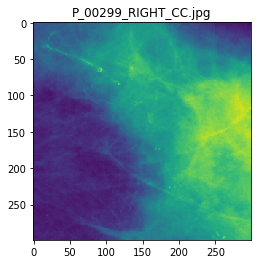

In [33]:
# check image to make sure it matches the cropped image
plt.imshow(calc_test_slices[76].reshape(299,299))
plt.title(calc_test_image_names[76])

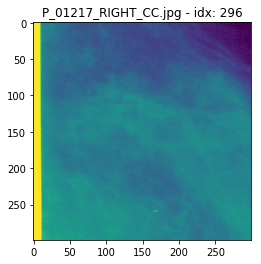

In [34]:
# P_00038_RIGHT_CC
for i in range(len(calc_test_image_names)):
    if calc_test_image_names[i] == "P_01217_RIGHT_CC.jpg":
        plt.imshow(calc_test_slices[i].reshape(299,299))
        plt.title("P_01217_RIGHT_CC.jpg - idx: " + str(i))
        plt.show()

In [35]:
test_labels = pd.read_pickle(os.path.join("data", "test_labels.pkl"))
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

calc_test_labels = []
for image in calc_test_image_names:
    label = test_labels.loc[image]['CLASS']
    calc_test_labels .append(test_labels.loc[image]['CLASS'])
    
print("Calc Test Labels:", len(calc_test_labels))

Calc Test Labels: 559


In [36]:
np.save(os.path.join("data", "calc_test_slices.npy"), calc_test_slices)
np.save(os.path.join("data", "calc_test_filenames.npy"), calc_test_image_names)
np.save(os.path.join("data", "calc_test_labels.npy"), np.array(calc_test_labels))

## Create File with All Slices

In [37]:
mass_train_labels = np.load(os.path.join("data", "mass_train_labels.npy"))
mass_test_labels = np.load(os.path.join("data", "mass_test_labels.npy"))
calc_train_labels = np.load(os.path.join("data", "calc_train_labels.npy"))
calc_test_labels = np.load(os.path.join("data", "calc_test_labels.npy"))
all_labels = np.concatenate([mass_train_labels, mass_test_labels, calc_train_labels, calc_test_labels], axis=0)

In [38]:
mass_train_slices = np.load(os.path.join("data", "mass_train_slices.npy"))
mass_test_slices = np.load(os.path.join("data", "mass_test_slices.npy"))
calc_train_slices = np.load(os.path.join("data", "calc_train_slices.npy"))
calc_test_slices = np.load(os.path.join("data", "calc_test_slices.npy"))
all_slices = np.concatenate([mass_train_slices, mass_test_slices, calc_train_slices, calc_test_slices], axis=0)

In [39]:
print("All labels:", all_labels.shape)
print("All slices:", all_slices.shape)

All labels: (4786,)
All slices: (4786, 299, 299, 1)


In [40]:
np.save(os.path.join("data", "all_slices.npy"), all_slices)
np.save(os.path.join("data", "all_labels.npy"), all_labels)

## Mask Sizes

The MIAS scans are sized 1024x1024 so have been scaled down. The DDSM images are full size and the regions of interest have been cut out of them at full size. We know the radius of the MIAS abnormalities, if we can get an average radius of DDSM abnormalities we can scale the MIAS data so that the sizes will match.

In [2]:
def get_mask_sizes(mask_dir, output=True):
    # loop through mask directory
    mask_files = os.listdir(mask_dir)
    mask_sizes = []
    
    for mask in mask_files:
        if output:
            print(mask)
        
        # get the mask, if the mask is bigger than the slice we will create multiple slices 
        # using the corners of the mask. 
        center_row, center_col, too_big, mask_size = create_mask(mask_dir + "/" + mask, return_size=True)
        mask_sizes.append(mask_size)
        
    return mask_sizes

In [3]:
## get the sizes of the masks as this will be used to scale the MIAS data properly
mask_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Mass Train All Mask JPEGs Full"

mass_train_mask_sizes = get_mask_sizes(mask_dir, output=False)

In [13]:
print("Mean ROI Radius Mass Train Data:", np.mean(mass_train_mask_sizes))
print("Median ROI Radius Mass Train Data:", np.median(mass_train_mask_sizes))
print("Min ROI Radius Mass Train Data:", np.min(mass_train_mask_sizes))
print("Max ROI Radius Mass Train Data:", np.max(mass_train_mask_sizes))

Mean ROI Radius Mass Train Data: 176.38161106590724
Median ROI Radius Mass Train Data: 159.0
Min ROI Radius Mass Train Data: 56
Max ROI Radius Mass Train Data: 681


In [9]:
## go through the directories and crop out the ROI from the full image using the mask
mask_dir = "D:\\Documents\\Mammography\\CBIS-DDSM\\Calc Train All Mask JPEGs Full"

calc_train_mask_sizes = get_mask_sizes(mask_dir, output=False)

In [15]:
print("Mean ROI Radius Calc Train Data:", np.mean(calc_train_mask_sizes))
print("Median ROI Radius Calc Train Data:", np.median(calc_train_mask_sizes))
print("Min ROI Radius Calc Train Data:", np.min(calc_train_mask_sizes))
print("Max ROI Radius Calc Train Data:", np.max(calc_train_mask_sizes))

Mean ROI Radius Calc Train Data: 271.4922575387123
Median ROI Radius Calc Train Data: 184.0
Min ROI Radius Calc Train Data: 20
Max ROI Radius Calc Train Data: 1899


In [16]:
all_mask_sizes = np.concatenate([mass_train_mask_sizes, calc_train_mask_sizes], axis=0)
                                 
print("Mean ROI Radius All Train Data:", np.mean(all_mask_sizes))
print("Median ROI Radius All Train Data:", np.median(all_mask_sizes))
print("Min ROI Radius All Train Data:", np.min(all_mask_sizes))
print("Max ROI Radius All Train Data:", np.max(all_mask_sizes))

Mean ROI Radius All Train Data: 223.89820846905536
Median ROI Radius All Train Data: 167.0
Min ROI Radius All Train Data: 20
Max ROI Radius All Train Data: 1899


<b>Compare to MIAS Data:</b><br>
Mean abnormality radius: 50.57657657657658<br>
Median abnormality radius: 41.0<br>
Min abnormality radius: 3.0<br>
Max abnormality radius: 197.0<br>

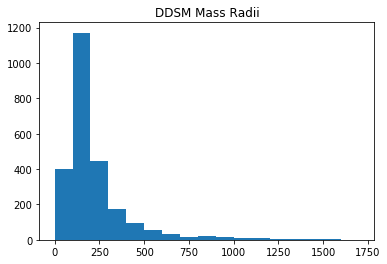

In [19]:
plt.hist(all_mask_sizes, bins=range(0, 1750, 100))
plt.title("DDSM Mass Radii")
plt.show()

<b>Compare to MIAS Radii</b>
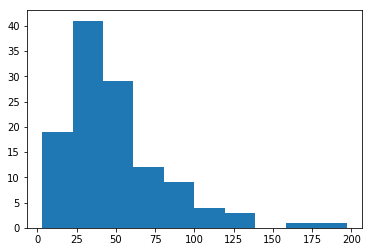

I am going to use an estimate of four to convert from the MIAS to DDSM data, as far as abnormality radii, so the MIAS data slices will be zoomed in by 4x to make them equivalent to the DDSM slices.